# Traveltime tomography using the Eikonal equation

@Author: Ettore Biondi - ebiondi@caltech.edu

In this notebook, we provide an example of how to solve a traveltime tomography problem using the solution to the Eikonal equation. This equation can be written as follows:
\begin{eqnarray}
\nabla \tau(\mathbf{x}) \cdot \nabla \tau(\mathbf{x})= \|\nabla \tau(\mathbf{x})\|^2 = \frac{1}{v^2(\mathbf{x})},
\end{eqnarray}
where $v$ is the wave speed, $\tau$ is the traveltime, and $\mathbf{x}$ denotes the spatial variables (i.e., $x$, $y$, and $z$). To solve the previous partial-differential equation (PDE), we employ the fast-marching method described by [Sethian (1996)](https://www.pnas.org/content/pnas/93/4/1591.full.pdf). The solution of the Eikonal equation depends non-linearly on the velocity parameter $v$. Hence, we express its discrete solution as follows:
\begin{eqnarray}
\pmb{\tau} = \mathbf{f}(\mathbf{v}).
\end{eqnarray}
The Jacobian $\mathbf{F}$ of the non-linear operator $\mathbf{f}$ obeys the following equation:
\begin{eqnarray}
2[\nabla \tau(\mathbf{x})] \cdot [\nabla \delta\tau(\mathbf{x})] = \delta v(\mathbf{x}),
\end{eqnarray}
where $\delta\tau$ represents the traveltime perturbation due to the velocity perturbation $\delta v(\mathbf{x})$. The previous relation when discretized represents a linear system of equations that can be solved by forward substitution [Li et al. (2013)](https://pi.math.cornell.edu/~vlad/papers/DSR_Geophysics_2013.pdf). 

In [1]:
import occamypy
import numpy as np
import os
import pkg_resources
import scipy.ndimage

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


Let's start by implementing the fast-marching method to solve the non-linear PDE defined by the Eikonal equation.

In [2]:
# Functions for solving Eikonal equation in 1D
import operator
def sorting(tt, idx, ordering="a"):
    if ordering == "a":
        sorted_indices = np.argsort(tt[idx])
    elif ordering == "d":
        sorted_indices = np.argsort(-tt[idx])
    else:
        raise ValueError("Unknonw ordering: %s! Provide a or d for ascending or descending" % ordering)
    
    # Sorting indices
    idx_sort = [idx[id] for id in sorted_indices]
    return idx_sort
# Fast-Marching-Method (FMM) 
def FMM_tt(tt, vv, dx, status, trial_idx):
    """Function to perform fast-marching method"""
    nx = vv.shape[0]
    dx_inv = 1.0 / dx
    # Various necessary variables
    drxns = [-1, 1]
    nbrs = np.zeros(2, dtype=int)
    # FFM main loop
    while len(trial_idx) > 0:
        # Getting trial point with smallest traveltime
        active_idx = trial_idx.pop(0)
        status[active_idx] = 'k'

        # Creating indices of neighbouring points
        for idx in range(2):
            nbrs[idx] = active_idx + drxns[idx]

        # Loop over neighbourning points
        for idx, nb in enumerate(nbrs):
            # If point is outside the domain or has a known traveltime skip it
            if nb < 0 or nb >= nx or status[nb] == 'k':
                continue
            # Checking if the velocity model is positive
            if vv[nb] > 0:
                fdt = np.zeros(2)
                order = np.zeros(2)
                # Computing forward and backward derivatives from nb
                for ii in range(2):
                    nb_i = nb + drxns[ii]
                    if (nb_i < nx and 0 <= nb_i) and status[nb_i] == 'k':
                        order[ii] = 1
                        fdt[ii] = drxns[ii] * (tt[nb_i]-tt[nb]) * dx_inv
                    else:
                        order[ii] = 0
                # Selecting upwind derivative 
                if fdt[0] > -fdt[1]:
                    ii, idrx = 0, -1
                else:
                    ii, idrx = 1, 1
                # Selecting correct neighbourning point
                nb_i = nb + idrx
                # Updating traveltime by solving quadratic equation
                if order[ii] == 0:
                    a = b = c = 0
                else:
                    a = dx_inv * dx_inv
                    b = -2 * a * tt[nb_i]
                    c = tt[nb_i] * tt[nb_i] * a - 1.0 / (vv[nb]*vv[nb])
                # Point out of bounds
                if a == 0:
                    continue
                det = b*b - 4.0*a*c
                if det < 0.0:
                    # Negative determinant; set it to zero
                    new_t = - b / (2 * a)
                else:
                    new_t = (- b + np.sqrt(det)) / (2*a)
                # Checking if new traveltime is smaller than current estimate for this point
                if new_t < tt[nb]:
                    tt[nb] = new_t
                    if status[nb] == 'u':
                        trial_idx.append(nb)
                        status[nb] = 't'
                    else:
                        trial_idx = sorting(tt, trial_idx)
    return

Let's wrap this function into an operator class.

In [3]:
class EikonalTT_1D(occamypy.Operator):

    def __init__(self, vel, tt_data, dx, SouPos, RecPos):
        """1D Eikonal-equation traveltime prediction operator"""
        # Setting Domain and Range of the operator
        self.setDomainRange(vel, tt_data)
        # Setting acquisition geometry
        self.nSou = SouPos.shape[0]
        self.nRec = RecPos.shape[0]
        self.SouPos = SouPos.copy()
        self.RecPos = RecPos.copy()
        dataShape = tt_data.shape
        if dataShape[0] != self.nSou:
            raise ValueError("Number of sources inconsistent with traveltime vector (shape[0])")
        if dataShape[1] != self.nRec:
            raise ValueError("Number of receivers inconsistent with traveltime vector (shape[1])")
        self.dx = dx
        self.nx = vel.shape[0]

    def forward(self, add, model, data):
        """Forward non-linear traveltime prediction"""
        self.checkDomainRange(model, data)
        if not add: 
            data.zero()
        dataNd = data.getNdArray()
        velNd = model.getNdArray()
        # Initialization
        tt = np.zeros(self.nx)
        for iShot in range(self.nSou):
            # Initial conditions
            status = np.array(["u"] * self.nx) # All points are unknown
            tt.fill(np.inf)
            trial_idx = []
            # Initial conditions
            idx = self.SouPos[iShot]
            tt[idx] = 0.0
            status[idx] = 't' # Trial status
            trial_idx.append(idx)
            # Sorting trial time ascending order
            trial_idx = sorting(tt, trial_idx)
            FMM_tt(tt, velNd, self.dx, status, trial_idx)     
            for iRec in range(self.nRec):
                dataNd[iShot, iRec] += tt[self.RecPos[iRec]]
        return

We can now use this operator to compute some traveltimes using a simple velocity model in which a Gaussian anomaly is placed at its center.

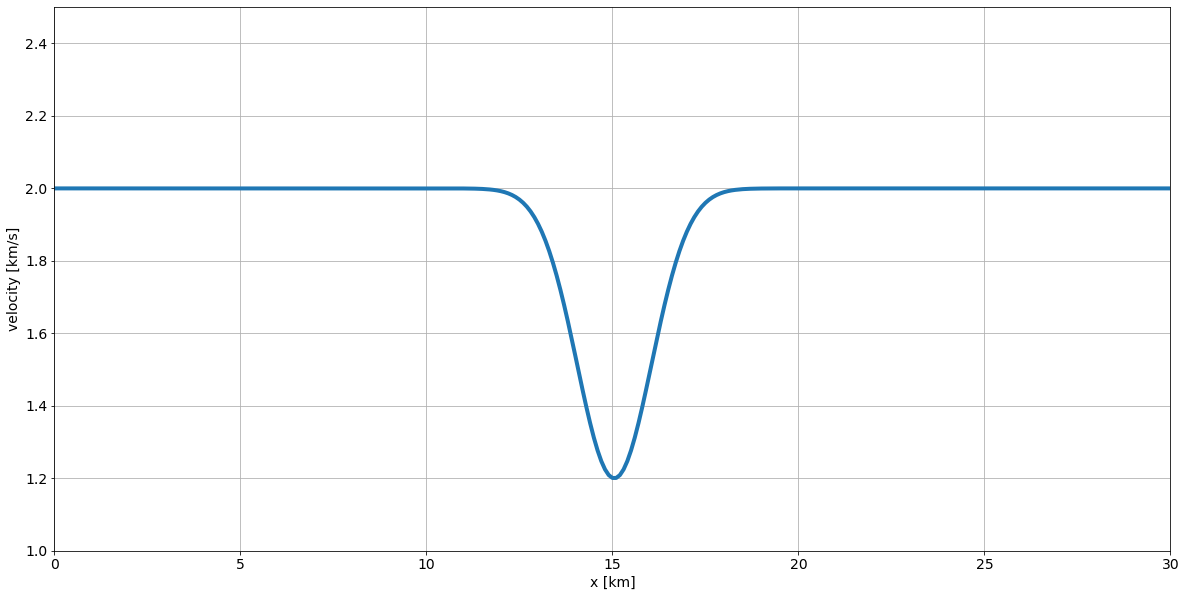

In [4]:
# Sampling along the z direction
dx = 0.1
nx = 301
x = np.linspace(0,(nx-1)*dx,nx)
# Velocity model
vv = occamypy.VectorNumpy(np.zeros(nx))
vv.set(2.0)
vv.getNdArray()[:] -= 0.8 * np.exp(-0.5*(x-(nx/2.0)*dx)**2)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, vv.getNdArray(), lw=4)
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("velocity [km/s]")
plt.ylim([1.0, 2.5])
ax.autoscale(enable=True, axis='x', tight=True)

Let's compute the traveltime for a single source and receivers at every grid point.

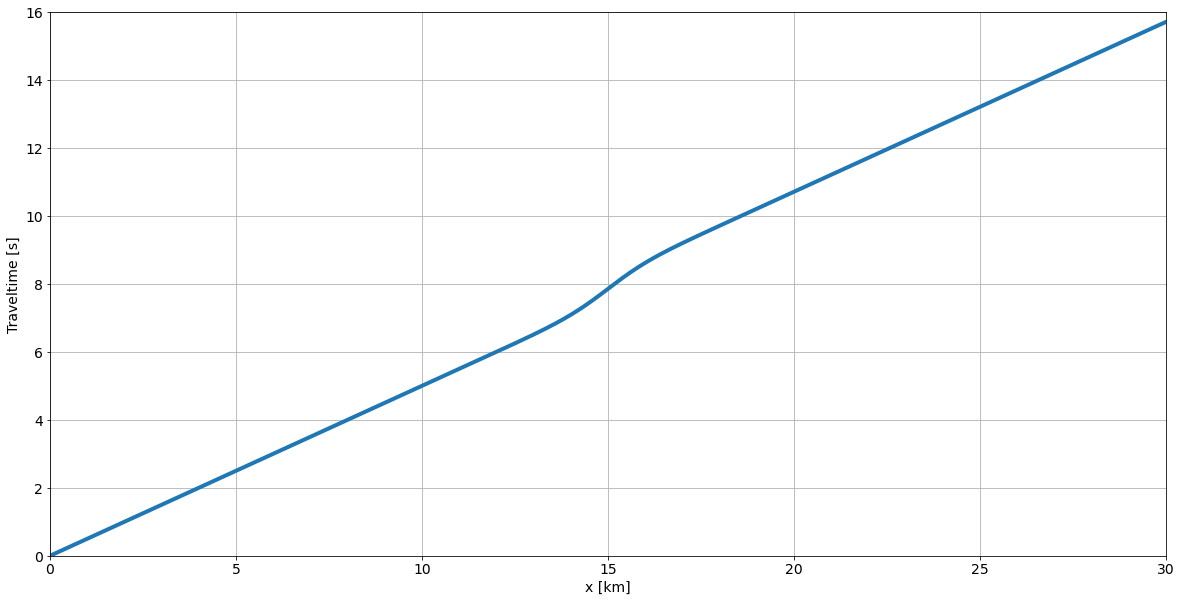

In [5]:
# Source/Receiver positions
SouPos = np.array([0])
RecPos = np.arange(0,nx)
# Data vector
tt_data = occamypy.VectorNumpy(np.zeros((SouPos.shape[0], RecPos.shape[0])))
# Setting Forward non-linear operator
Eik1D_Op = EikonalTT_1D(vv, tt_data, dx, SouPos, RecPos)
Eik1D_Op.forward(False, vv, tt_data)

# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(RecPos*dx, tt_data.getNdArray()[0, :], lw=4)
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("Traveltime [s]")
plt.ylim([0.0, 16.0])
ax.autoscale(enable=True, axis='x', tight=True)

Let's implement and test the linearized Eikonal equation operators. Again we first define the functions to solve the forward and adjoint PDEs, and then we wrap it within an operator class.

In [6]:
def FMM_tt_lin_fwd(delta_v, delta_tt, vv, tt, dx):
    """Fast-marching method linearized forward in 1D"""
    nx = delta_v.shape[0]
    drxns = [-1, 1]
    nbrs = np.zeros(2, dtype=int)
    dx_inv = 1.0 / dx
    
    tt_idx = np.arange(nx)
    # Sorting traveltime in ascending order
    tt_idx = sorting(tt, tt_idx)
    
    # Scaling the velocity perturbation
    delta_v_scaled = - 2.0 * delta_v / (vv * vv * vv)

    # Looping over all indices to solve linear equations from increasing traveltime values
    for idx_t0 in tt_idx:
        # If T = 0 or v = 0, then assuming zero to avoid singularity
        if tt[idx_t0] == 0.0 or vv[idx_t0] == 0.0:
            continue
        # Creating indices of neighbouring points
        for idx in range(2):
            nbrs[idx] = idx_t0 + drxns[idx]

        # Loop over neighbourning points to find up-wind direction
        fdt = np.zeros(2)
        order = np.zeros(2, dtype=int)
        for idx, nb in enumerate(nbrs):
            # If point is outside the domain skip it
            if nb < 0 or nb >= nx:
                continue
            if vv[nb] > 0.0:
                order[idx] = 1
                fdt[idx] = drxns[idx] * (tt[nb]-tt[idx_t0]) * dx_inv
            else:
                order[idx] = 0
        # Selecting upwind derivative 
        if fdt[0] > -fdt[1] and order[0] > 0:
            ii, idrx = 0, -1
        else:
            ii, idrx = 1, 1
        # Computing t0 space derivative
        fdt0 = idrx * (tt[idx_t0 + idrx] - tt[idx_t0]) * dx_inv * dx_inv
        delta_tt[idx_t0] += (2.0 * fdt0 * delta_tt[idx_t0 + idrx] - idrx * delta_v_scaled[idx_t0]) / (2.0 * fdt0)
    return

In [7]:
def select_upwind_der(tt, idx_t0, vv, dx_inv):
    nbrs = np.zeros(2, dtype=int)
    drxns = [-1, 1]
    # Creating indices of neighbouring points
    for idx in range(2):
        nbrs[idx] = idx_t0 + drxns[idx]

    # Loop over neighbourning points to find up-wind direction
    fdt = np.zeros(2)
    order = np.zeros(2, dtype=int)
    for idx, nb in enumerate(nbrs):
        # If point is outside the domain skip it
        if nb < 0 or nb >= nx:
            continue
        if vv[nb] > 0.0:
            order[idx] = 1
            fdt[idx] = drxns[idx] * (tt[nb]-tt[idx_t0]) * dx_inv
        else:
            order[idx] = 0
    # Selecting upwind derivative 
    if fdt[0] > -fdt[1] and order[0] > 0:
        idrx = -1
    else:
        idrx = 1
    return idrx, order
            
def FMM_tt_lin_adj(delta_v, delta_tt, vv, tt, dx):
    """Fast-marching method linearized adjoint in 1D"""
    nx = delta_v.shape[0]
    dx_inv = 1.0 / dx
    tt_idx = np.arange(nx)
    # Sorting traveltime in descending order
    tt_idx = sorting(tt, tt_idx, ordering="d")
    
    # Looping over all indices to solve linear equations from increasing traveltime values
    for idx_t0 in tt_idx:
        # Identify the type of row (i.e., central, edge, or initial conditions)
        if tt[idx_t0] == 0.0 or vv[idx_t0] == 0.0:
            continue
        else:
            idrx0, order0 = select_upwind_der(tt, idx_t0, vv, dx_inv)
            # Computing k0 (derivative coefficient at the current index)
            k0 = 2.0 * np.sign(idrx0) * idrx0 * (tt[idx_t0 + idrx0] - tt[idx_t0]) * dx_inv * dx_inv
            nb = idx_t0 - idrx0
            # Checking if at a boundary
            if nb < 0 or nb >= nx:
                delta_v[idx_t0] =  delta_tt[idx_t0] / k0
            else:
                # Computing k1 (derivative coefficient at the forward or backgward index)
                idrx1, order1 = select_upwind_der(tt, nb, vv, dx_inv)
                k_fb = 2.0 * np.sign(idrx1) * idrx1 * (tt[nb + idrx1] - tt[nb]) * dx_inv * dx_inv
                delta_v[idx_t0] += (delta_tt[idx_t0] + k_fb * delta_v[nb]) / k0
            
    # Scaling the velocity perturbation
    delta_v[:] = 2.0 * delta_v / (vv * vv * vv)
    return

In [8]:
class EikonalTT_lin_1D(occamypy.Operator):

    def __init__(self, vel, tt_data, dx, SouPos, RecPos):
        """1D Eikonal-equation traveltime prediction operator"""
        # Setting Domain and Range of the operator
        self.setDomainRange(vel, tt_data)
        # Setting acquisition geometry
        self.nSou = SouPos.shape[0]
        self.nRec = RecPos.shape[0]
        self.SouPos = SouPos.copy()
        self.RecPos = RecPos.copy()
        dataShape = tt_data.shape
        if dataShape[0] != self.nSou:
            raise ValueError("Number of sources inconsistent with traveltime vector (shape[0])")
        if dataShape[1] != self.nRec:
            raise ValueError("Number of receivers inconsistent with traveltime vector (shape[1])")
        self.dx = dx
        self.nx = vel.shape[0]
        # Background model
        self.vel = vel.clone()
        self.vel.copy(vel)

    def forward(self, add, model, data):
        """Forward linearized traveltime prediction"""
        self.checkDomainRange(model, data)
        if not add: 
            data.zero()
        dataNd = data.getNdArray()
        modelNd = model.getNdArray()
        vel0Nd = self.vel.getNdArray()
        # Initialization
        tt0 = np.zeros(self.nx)
        for iShot in range(self.nSou):
            ###################################
            # Computing background traveltime #
            ###################################
            # Initial conditions
            status = np.array(["u"] * self.nx) # All points are unknown
            tt0.fill(np.inf)
            trial_idx = []
            # Initial conditions
            idx = self.SouPos[iShot]
            tt0[idx] = 0.0
            status[idx] = 't' # Trial status
            trial_idx.append(idx)
            # Sorting trial time ascending order
            trial_idx = sorting(tt0, trial_idx)
            FMM_tt(tt0, vel0Nd, self.dx, status, trial_idx) 
            ###################################
            # Computing linearized traveltime #
            ###################################
            delta_tt = np.zeros(self.nx)
            FMM_tt_lin_fwd(modelNd, delta_tt, vel0Nd, tt0, self.dx)
            for iRec in range(self.nRec):
                dataNd[iShot, iRec] += delta_tt[self.RecPos[iRec]]
        return
    
    def adjoint(self, add, model, data):
        """Adjoint linearized traveltime prediction"""
        self.checkDomainRange(model, data)
        if not add: 
            model.zero()
        dataNd = data.getNdArray()
        modelNd = model.getNdArray()
        vel0Nd = self.vel.getNdArray()
        # Initialization
        tt0 = np.zeros(self.nx)
        for iShot in range(self.nSou):
            ###################################
            # Computing background traveltime #
            ###################################
            # Initial conditions
            status = np.array(["u"] * self.nx) # All points are unknown
            tt0.fill(np.inf)
            trial_idx = []
            # Initial conditions
            idx = self.SouPos[iShot]
            tt0[idx] = 0.0
            status[idx] = 't' # Trial status
            trial_idx.append(idx)
            # Sorting trial time ascending order
            trial_idx = sorting(tt0, trial_idx)
            FMM_tt(tt0, vel0Nd, self.dx, status, trial_idx) 
            ###################################
            # Computing velocity perturbation #
            ###################################
            delta_tt = np.zeros(self.nx)
            delta_v = np.zeros(self.nx)
            # Injecting traveltime to correct grid positions
            for iRec in range(self.nRec):
                delta_tt[self.RecPos[iRec]] = dataNd[iShot, iRec]
            FMM_tt_lin_adj(delta_v, delta_tt, vel0Nd, tt0, self.dx)
            modelNd[:] += delta_v
        return
    
    def set_vel(self, vel):
        """Function to set background velocity model"""
        self.vel.copy(vel)

Let's start by testing the adjointness of the forward and adjoint methods.

In [9]:
# Dot-product test for the linearized Eikonal equation in 1D
Eik1D_Lin_Op = EikonalTT_lin_1D(vv, tt_data, dx, SouPos, RecPos)
Eik1D_Lin_Op.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 0.009997129440307617 seconds
Applying adjoint operator add=False
 Runs in: 0.016707181930541992 seconds
Dot products add=False: domain=9.216393e-01 range=9.216393e-01 
Absolute error: 3.330669e-16
Relative error: 3.613853e-16 

Applying forward operator add=True
 Runs in: 0.009383916854858398 seconds
Applying adjoint operator add=True
 Runs in: 0.01908707618713379 seconds
Dot products add=True: domain=1.843279e+00 range=1.843279e+00 
Absolute error: 6.661338e-16
Relative error: 3.613853e-16 

-------------------------------------------------


The linearization error of the linearized Eikonal operator $\mathbf{F}$ should follow:
\begin{eqnarray}
e = \|\mathbf{f}(\mathbf{v}+\alpha\Delta\mathbf{v})-\mathbf{f}(\mathbf{v})-\alpha\mathbf{F}(\mathbf{v})\Delta\mathbf{v}\|_2=\mathcal{O}(\alpha^2) \;\rm{as}\; \alpha \to 0,
\end{eqnarray}
where $\alpha$ is the scale associated with the velocity perturbation $\Delta\mathbf{v}$. Let's test if this is the case for our operator.

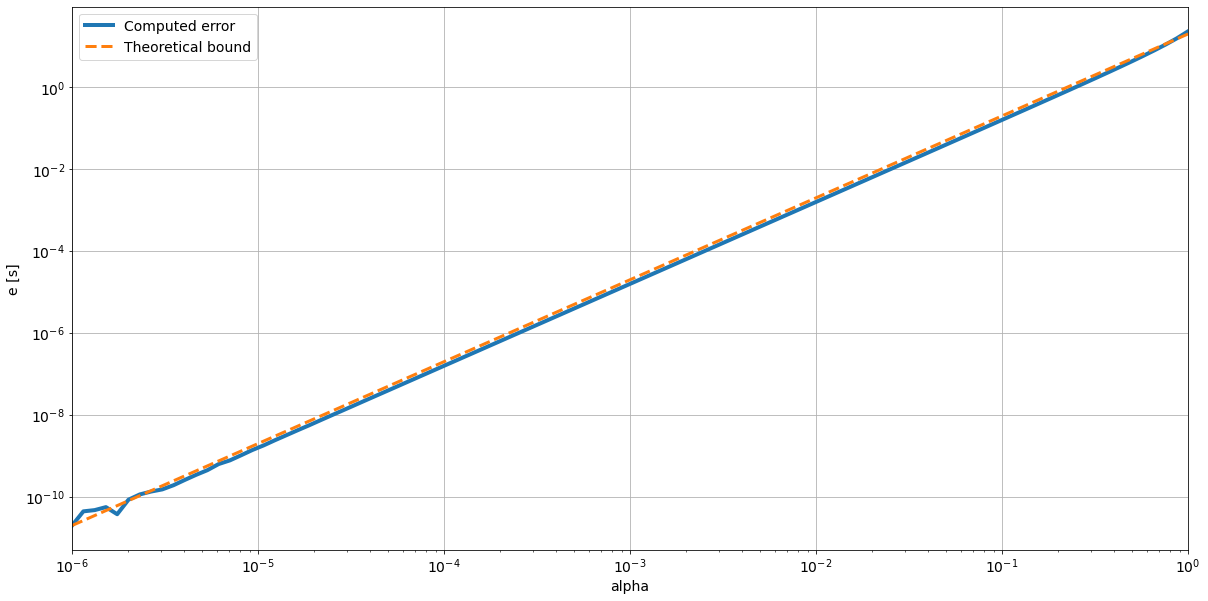

In [10]:
Eik1D_NlOp = occamypy.NonlinearOperator(Eik1D_Op, Eik1D_Lin_Op, Eik1D_Lin_Op.set_vel)
alpha, err = Eik1D_NlOp.linTest(vv)
M = err[0]/(alpha[0]*alpha[0])
fig, ax = plt.subplots(figsize=(20,10))
ax.loglog(alpha,err, lw=4, label="Computed error")
ax.loglog(alpha,M*alpha*alpha, lw=3, ls="--", label="Theoretical bound")
ax.grid()
plt.xlabel("alpha")
plt.ylabel("e [s]")
plt.legend()
ax.autoscale(enable=True, axis='x', tight=True)

## Eikonal traveltime tomography 

Now that we are confident that our operators are working properly, we can set up an inversion problem. We are going to solve a bounded non-linear L2-norm problem defined as follows:
\begin{equation}
\phi(\mathbf{v}) = \frac{1}{2}\|\mathbf{f}(\mathbf{v}) - \pmb{\tau}_{obs}\|_2^2,\\
\text{s.t.} \; \mathbf{v}_{l} \leq \mathbf{v} \leq \mathbf{v}_{u}
\end{equation}

In [11]:
# Source/Receiver positions
SouPos = np.arange(0, nx, 150)
RecPos = np.arange(0, nx, 10)
# Data vector
tt_data = occamypy.VectorNumpy(np.zeros((SouPos.shape[0], RecPos.shape[0])))
tt_data
# Instantiating non-linear operator
Eik1D_Op = EikonalTT_1D(vv, tt_data, dx, SouPos, RecPos)
Eik1D_Op.forward(False, vv, tt_data)
Eik1D_Lin_Op = EikonalTT_lin_1D(vv, tt_data, dx, SouPos, RecPos)
Eik1D_NlOp = occamypy.NonlinearOperator(Eik1D_Op, Eik1D_Lin_Op, Eik1D_Lin_Op.set_vel)

Let's generated the observed data using 3 sources and receivers every 1 km.

In [12]:
# Creating observed data
Eik1D_Op.forward(False, vv, tt_data)
tt_data_obs = tt_data.clone()

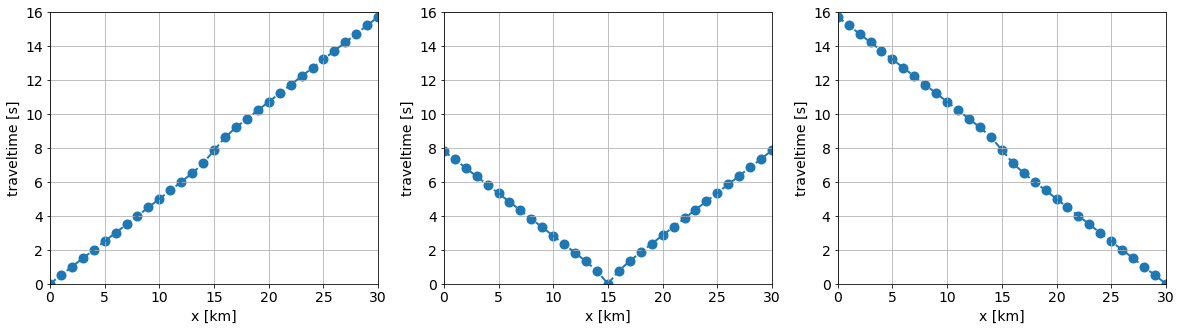

In [13]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
# Plotting first shot
ax1.scatter(RecPos*dx, tt_data_obs.getNdArray()[0,:], linewidth=4)
ax1.plot(RecPos*dx, tt_data_obs.getNdArray()[0,:], ls="--", linewidth=2)
ax1.set_ylabel("traveltime [s]")
ax1.set_xlabel("x [km]")
ax1.set_ylim([0.0, 16.0])
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid()
# Plotting middle shot
ax2.scatter(RecPos*dx, tt_data_obs.getNdArray()[1,:], linewidth=4)
ax2.plot(RecPos*dx, tt_data_obs.getNdArray()[1,:], ls="--", linewidth=2)
ax2.set_ylabel("traveltime [s]")
ax2.set_xlabel("x [km]")
ax2.set_ylim([0.0, 16.0])
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.grid()
# Plotting last shot
ax3.scatter(RecPos*dx, tt_data_obs.getNdArray()[2,:], linewidth=4)
ax3.plot(RecPos*dx, tt_data_obs.getNdArray()[2,:], ls="--", linewidth=2)
ax3.set_ylabel("traveltime [s]")
ax3.set_xlabel("x [km]")
ax3.set_ylim([0.0, 16.0])
ax3.autoscale(enable=True, axis='x', tight=True)
ax3.grid()

We start the inversion by assuming a velocity model in which the Gaussian anomaly is not present.

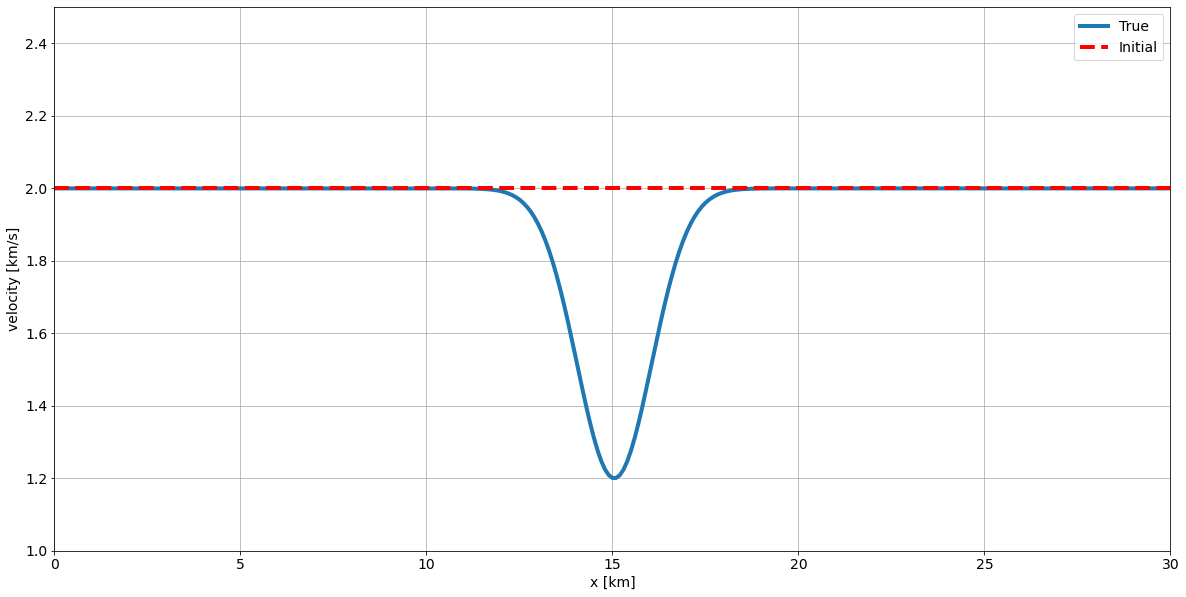

In [14]:
vv_init = vv.clone().set(2.0)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, vv.getNdArray(), lw=4, label="True")
ax.plot(x, vv_init.getNdArray(), c="red", ls="--", lw=4, label="Initial")
ax.grid()
ax.legend()
plt.xlabel("x [km]")
plt.ylabel("velocity [km/s]")
plt.ylim([1.0, 2.5])
ax.autoscale(enable=True, axis='x', tight=True)

Let's compare the traveltime difference between the initially predicted and observed traveltimes for each source.

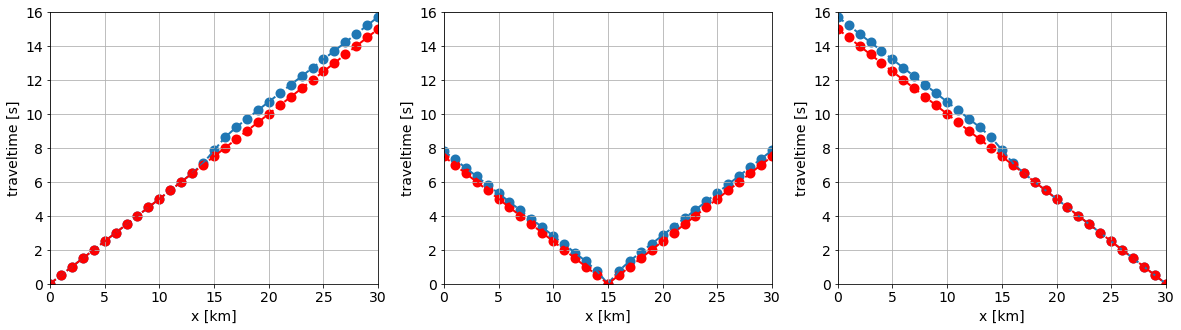

In [15]:
# Creating initial data
Eik1D_Op.forward(False, vv_init, tt_data)

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
# Plotting first shot
ax1.scatter(RecPos*dx, tt_data_obs.getNdArray()[0,:], linewidth=4)
ax1.plot(RecPos*dx, tt_data_obs.getNdArray()[0,:], ls="--", linewidth=2, label="observed data")
ax1.scatter(RecPos*dx, tt_data.getNdArray()[0,:], c="red", linewidth=4)
ax1.plot(RecPos*dx, tt_data.getNdArray()[0,:], c="red", ls="--", linewidth=2, label="initial data")
ax1.set_ylabel("traveltime [s]")
ax1.set_xlabel("x [km]")
ax1.set_ylim([0.0, 16.0])
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid()
# Plotting middle shot
ax2.scatter(RecPos*dx, tt_data_obs.getNdArray()[1,:], linewidth=4)
ax2.plot(RecPos*dx, tt_data_obs.getNdArray()[1,:], ls="--", linewidth=2, label="observed data")
ax2.scatter(RecPos*dx, tt_data.getNdArray()[1,:], c="red",  linewidth=4)
ax2.plot(RecPos*dx, tt_data.getNdArray()[1,:], c="red", ls="--", linewidth=2, label="initial data")
ax2.set_ylabel("traveltime [s]")
ax2.set_xlabel("x [km]")
ax2.set_ylim([0.0, 16.0])
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.grid()
# Plotting last shot
ax3.scatter(RecPos*dx, tt_data_obs.getNdArray()[2,:], linewidth=4)
ax3.plot(RecPos*dx, tt_data_obs.getNdArray()[2,:], ls="--", linewidth=2,label="observed data")
ax3.scatter(RecPos*dx, tt_data.getNdArray()[2,:], c="red",  linewidth=4)
ax3.plot(RecPos*dx, tt_data.getNdArray()[2,:], c="red", ls="--", linewidth=2, label="initial data")
ax3.set_ylabel("traveltime [s]")
ax3.set_xlabel("x [km]")
ax3.set_ylim([0.0, 16.0])
ax3.autoscale(enable=True, axis='x', tight=True)
ax3.grid()

We now solve the non-linear constrained optimization problem using the solver L-BFGS-B.

In [16]:
v_min = 1.0
v_max = 3.0
minBound = occamypy.VectorNumpy(np.ones(nx)*v_min)
maxBound = occamypy.VectorNumpy(np.ones(nx)*v_max)
niter = 250
Stop  = occamypy.BasicStopper(niter=niter, tolg_proj=1e-32)
!rm -f test.txt
BFGSBsolver = occamypy.LBFGSB(Stop, m_steps=30)
# Creating problem object using Smoothing filter and Gradient mask
filt = occamypy.VectorNumpy(np.ones(15))
SmoothOp = occamypy.ConvND(vv_init, filt)
Mask = occamypy.VectorNumpy(np.zeros(nx))
Mask.getNdArray()[int(nx*0.25):int(nx*0.75)] = 1.0
SmoothOp.forward(False, Mask, Mask.clone())
Eik1D_Inv_NlOp = occamypy.NonlinearOperator(Eik1D_Op, Eik1D_Lin_Op*SmoothOp, Eik1D_Lin_Op.set_vel)
L2_tt_prob = occamypy.NonlinearLeastSquares(vv_init.clone(), tt_data_obs, Eik1D_Inv_NlOp, 
                                            minBound=minBound, maxBound=maxBound, grad_mask=Mask)

In [17]:
BFGSBsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Bounds (L-BFGS-B) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 30 
Restart folder: /tmp/restart_2021-03-25T17-28-48.281653/
##########################################################################################

iter = 000, obj = 9.36512e+00, resnorm = 4.33e+00, gradnorm = 1.08e+02, feval = 1, geval = 1
iter = 001, obj = 3.46916e+00, resnorm = 2.63e+00, gradnorm = 6.77e+01, feval = 2, geval = 2
iter = 002, obj = 8.95147e-01, resnorm = 1.34e+00, gradnorm = 2.91e+01, feval = 3, geval = 3
iter = 003, obj = 4.79319e-01, resnorm = 9.79e-01, gradnorm = 6.28e+00, feval = 4, geval = 4
iter = 004, obj = 4.49458e-01, resnorm = 9.48e-01, gradnorm = 4.90e+00, feval = 5, geval = 5
iter = 005, obj = 3.48906e-01, resnorm = 8.35e-01, gradnorm = 4.73e+00, feval = 6, geval = 6
iter = 006, obj = 3.13463e-01, resnorm = 7.92e-01

iter = 085, obj = 2.89658e-04, resnorm = 2.41e-02, gradnorm = 4.22e-02, feval = 86, geval = 86
iter = 086, obj = 2.79828e-04, resnorm = 2.37e-02, gradnorm = 1.15e-01, feval = 87, geval = 87
iter = 087, obj = 2.73558e-04, resnorm = 2.34e-02, gradnorm = 3.93e-02, feval = 88, geval = 88
iter = 088, obj = 2.17045e-04, resnorm = 2.08e-02, gradnorm = 1.58e-01, feval = 89, geval = 89
iter = 089, obj = 2.06663e-04, resnorm = 2.03e-02, gradnorm = 4.92e-02, feval = 90, geval = 90
iter = 090, obj = 2.04537e-04, resnorm = 2.02e-02, gradnorm = 3.97e-02, feval = 91, geval = 91
iter = 091, obj = 2.01951e-04, resnorm = 2.01e-02, gradnorm = 4.92e-02, feval = 92, geval = 92
iter = 092, obj = 1.99884e-04, resnorm = 2.00e-02, gradnorm = 3.84e-02, feval = 93, geval = 93
iter = 093, obj = 1.97190e-04, resnorm = 1.99e-02, gradnorm = 5.08e-02, feval = 94, geval = 94
iter = 094, obj = 1.95147e-04, resnorm = 1.98e-02, gradnorm = 3.67e-02, feval = 95, geval = 95
iter = 095, obj = 1.92158e-04, resnorm = 1.96e-02,

iter = 170, obj = 1.13253e-05, resnorm = 4.76e-03, gradnorm = 6.59e-03, feval = 171, geval = 171
iter = 171, obj = 1.08226e-05, resnorm = 4.65e-03, gradnorm = 2.67e-02, feval = 172, geval = 172
iter = 172, obj = 1.05093e-05, resnorm = 4.58e-03, gradnorm = 6.47e-03, feval = 173, geval = 173
iter = 173, obj = 1.02067e-05, resnorm = 4.52e-03, gradnorm = 1.81e-02, feval = 174, geval = 174
iter = 174, obj = 1.00466e-05, resnorm = 4.48e-03, gradnorm = 6.04e-03, feval = 175, geval = 175
iter = 175, obj = 8.80062e-06, resnorm = 4.20e-03, gradnorm = 4.02e-02, feval = 176, geval = 176
iter = 176, obj = 8.14592e-06, resnorm = 4.04e-03, gradnorm = 9.63e-03, feval = 177, geval = 177
iter = 177, obj = 8.08421e-06, resnorm = 4.02e-03, gradnorm = 5.73e-03, feval = 178, geval = 178
iter = 178, obj = 7.97379e-06, resnorm = 3.99e-03, gradnorm = 1.14e-02, feval = 179, geval = 179
iter = 179, obj = 7.90062e-06, resnorm = 3.98e-03, gradnorm = 5.31e-03, feval = 180, geval = 180
iter = 180, obj = 7.59873e-06,

Let's see if the inversion was able to retrieve the Gaussian anomaly.

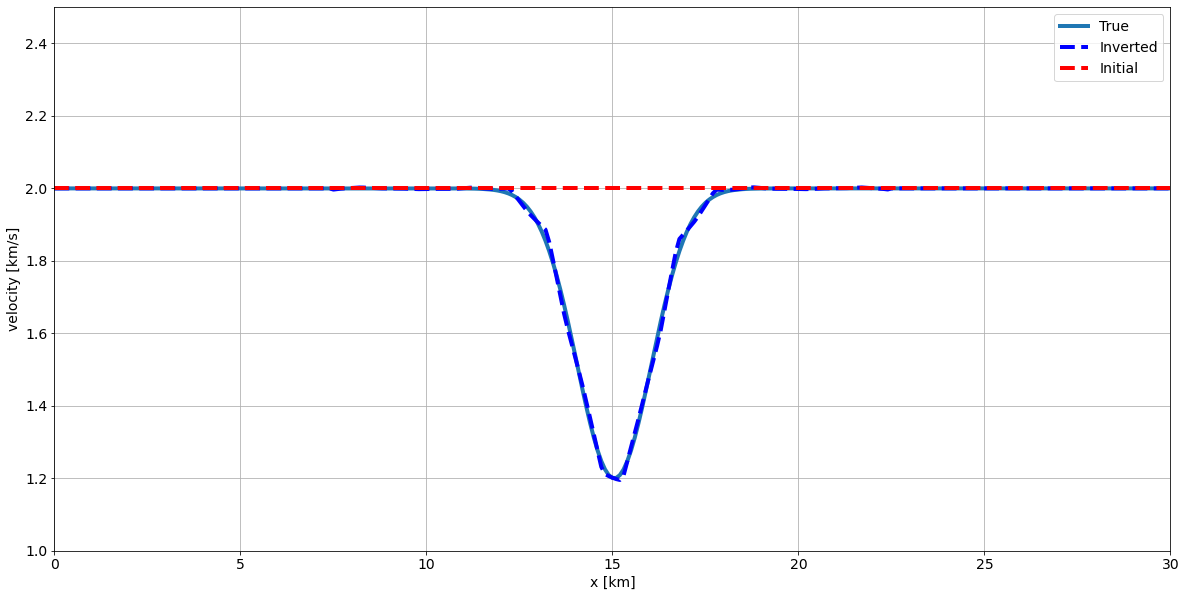

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x, vv.getNdArray(), lw=4, label="True")
ax.plot(x, L2_tt_prob.model.getNdArray(), c="blue", ls="--", lw=4, label="Inverted")
ax.plot(x, vv_init.getNdArray(), c="red", ls="--", lw=4, label="Initial")
ax.grid()
ax.legend()
plt.xlabel("x [km]")
plt.ylabel("velocity [km/s]")
plt.ylim([1.0, 2.5])
ax.autoscale(enable=True, axis='x', tight=True)